In [1]:
# tensorflow_text needs to be installed by running this command from terminal
# pip install -q tensorflow_text==2.9.0

# Import Libraries

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import os
import nltk
import re
import string
import pickle

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
from wordcloud import WordCloud

In [2]:
# Load dataset

train_ori = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")
train_ori.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_ori.shape

(159571, 8)

In [4]:
train_df = train_ori.copy() # Copy the dataframe to avoid accidentally editing it.

train_df["safe"] = 1 # Create new "safe" column and assign the values to 1

# Iterate through the rows and wherever a comment has been given any of the already existing
#labels, change the "safe" column value to 0.
for i, row in train_df.iterrows():
    if (row["toxic"] or row["severe_toxic"] or row["obscene"] or row["threat"] 
        or row["insult"] or row["identity_hate"]):
        train_df.iloc[i, train_df.columns.get_loc("safe")] = 0
        
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [5]:
# Drop "id" column since it adds no valuable information to the model.

train_df.drop(columns="id", inplace=True)
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   safe           159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


In [7]:
# Check for duplicate rows

num_of_duplicates = sum(train_df.duplicated().to_list())
num_of_duplicates

0

## Data Cleaning and Preprocessing

In [8]:
STOPWORDS = stopwords.words("english")

WORDNET_LEMMATIZER = WordNetLemmatizer()

In [9]:
# Build helper function to handle various aspects of the cleaning and preprocessing

def clean_comments(comment):
    """
    Takes in texts and cleans them to allow for better model performance.This done by 
    changing to lowercase, removing links, removing punctuations and other steps.
    
    Args:
        comment (str): The comment to be cleaned.
    
    Returns:
        clean_comment (str): The comment which has been cleaned.
    """
    
    comment = comment.lower() # Change to lowercase
    comment = re.sub("https?://\S+|www\.\S+"," ",comment) # Remove links
    comment = re.sub("<.*?>+"," ",comment) # Remove unwanted characters
    comment = re.sub("[%s]" % re.escape(string.punctuation)," ",comment) # Remove punctuations
    comment = re.sub("\n"," ",comment) # Remove next line symbols '\n'
    
    # Split the comment into individual words and only join the words that are not part of the  
    # "STOPWORDS" set back into a single comment sentence.
    comment = " ".join(word for word in comment.split(" ") if word not in STOPWORDS)
    
    # Split the comment into individual words and only join the lemmatized words 
    # back into a single comment sentence.
    clean_comment = " ".join(WORDNET_LEMMATIZER.lemmatize(word) for word in comment.split(" "))
    
    return clean_comment

In [10]:
train_df["clean_comment"] = train_df["comment_text"].apply(lambda comment : clean_comments(comment))
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe,clean_comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantl...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestion improvement wondered ...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page


## EDA

In [11]:
# Plot histogram for the comment lengths.

train_df["comment_len"] = train_df["clean_comment"].str.len()

fig = px.histogram(train_df,
                   x="comment_len",
                   title="Histogram of Comment Lengths",
                   opacity=0.8,
                   log_y=True,
                   color_discrete_sequence=["blue"]
                  )
fig.show()

In [12]:
# Find out the number of comments in each class.

fig = make_subplots(rows=3, 
                    cols=3,
                    subplot_titles=("Toxic", 
                                    "Severe toxic",
                                    "Obscene", 
                                    "Threat",
                                    "Insult", 
                                    "Identity hate",
                                    "",
                                    "Safe"
                                   )
                   )

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['toxic'].value_counts()),
              row=1, col=1)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['severe_toxic'].value_counts()),
              row=1, col=2)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['obscene'].value_counts()),
              row=1, col=3)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['threat'].value_counts()),
              row=2, col=1)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['insult'].value_counts()),
              row=2, col=2)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['identity_hate'].value_counts()),
             row = 2,col = 3)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train_df['safe'].value_counts()),
             row = 3,col = 2)
              
fig.update_layout(showlegend=False)
fig.show()

In [13]:
# Create seperate dataframes for the safe and unsafe comments

safe_comments_df = train_df[train_df["safe"]==1]
unsafe_comments_df = train_df[train_df["safe"]==0]

In [14]:
# Find out the average length of safe comments vs. that of unsafe comments

safe_comments_avg_len = safe_comments_df["comment_len"].mean().round(0)
unsafe_comments_avg_len = unsafe_comments_df["comment_len"].mean().round(0)

print(f"Safe Comments Average Length: {safe_comments_avg_len}\nUnsafe Comments Average Length: {unsafe_comments_avg_len}")

Safe Comments Average Length: 269.0
Unsafe Comments Average Length: 205.0


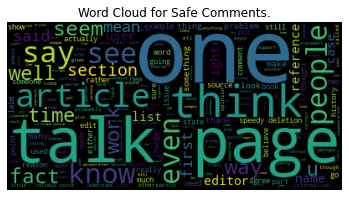

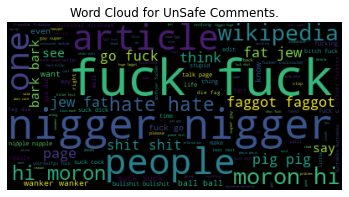

In [15]:
# Build word clouds for the safe and unsafe comments

safe_comments_worldcloud = WordCloud().generate(' '.join(safe_comments_df["clean_comment"])) # Concatenate all words in df column
                                                                                             # and count instances.

plt.imshow(safe_comments_worldcloud)
plt.title("Word Cloud for Safe Comments.")
plt.axis("off")
plt.show()

unsafe_comments_worldcloud = WordCloud().generate(' '.join(unsafe_comments_df["clean_comment"]))
plt.imshow(unsafe_comments_worldcloud)
plt.title("Word Cloud for UnSafe Comments.")
plt.axis("off")
plt.show()

## Model Building and Training.

In [16]:
#Generate list of target classes

target_classes = train_df.columns.to_list()[1:-2]
target_classes

['toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'safe']

In [17]:
X = train_df["clean_comment"]
y = train_df[target_classes]

# Split dataset inro train and validation sets 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X_train: (127656,)
y_train: (127656, 7)
X_val: (31915,)
y_val: (31915, 7)


In [18]:
# Load BERT encoder and preprocessor from TensorFlow Hub

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
                         trainable=False)

In [19]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
dropout = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
dense = tf.keras.layers.Dense(len(target_classes), activation='sigmoid')(dropout)

model = tf.keras.Model(inputs=[text_input], outputs=[dense])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [20]:
# Define custom callback to prevent model overfitting 
# Inherit from keras callbacks class

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Stop training when training accuracy reaches 99%
        if logs.get("accuracy") is not None and logs.get("accuracy") > 0.99:
            print("\n Training reached 99% accuracy. \n Stopping Training --------")
            self.model.stop_training = True

In [21]:
callback = myCallback()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/5
3990/3990 [==============================] - 1104s 274ms/step - loss: 0.1169 - accuracy: 0.9152 - val_loss: 0.1013 - val_accuracy: 0.9250
Epoch 2/5
3990/3990 [==============================] - 1095s 275ms/step - loss: 0.1004 - accuracy: 0.9234 - val_loss: 0.0953 - val_accuracy: 0.9296
Epoch 3/5
3990/3990 [==============================] - 1103s 277ms/step - loss: 0.0978 - accuracy: 0.9248 - val_loss: 0.0954 - val_accuracy: 0.9302
Epoch 4/5
3990/3990 [==============================] - 1108s 278ms/step - loss: 0.0971 - accuracy: 0.9246 - val_loss: 0.0918 - val_accuracy: 0.9303
Epoch 5/5
3990/3990 [==============================] - 1105s 277ms/step - loss: 0.0960 - accuracy: 0.9250 - val_loss: 0.0906 - val_accuracy: 0.9297


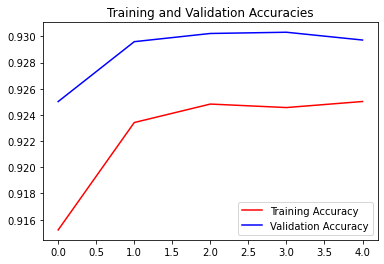

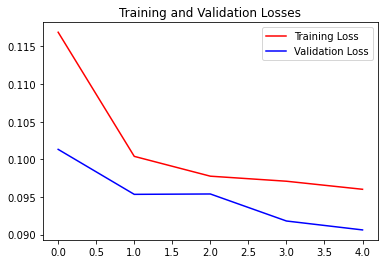

In [23]:
# Plot loss and accuracy curves for model evaluation

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "red", label="Training Accuracy")
plt.plot(epochs, val_acc, "blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()

plt.plot(epochs, loss, "red", label="Training Loss")
plt.plot(epochs, val_loss, "blue", label="Validation Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

In [28]:
model.predict(["Praise God Almighty"])

1/1 [==============================] - 0s 40ms/step


array([[0.1676843 , 0.00384315, 0.05366671, 0.01047436, 0.04469893,
        0.00681222, 0.84351224]], dtype=float32)

In [29]:
model.save("model.h5")